### Automating protest categories (MSA 2020) 
Using machine learning to predict protester demands based on protest descriptions. 

In light of recent civil unrest, including #blacklivesmatter and #metoo movements,it has never been more important for people in positions of power to listen citizen voices.

<p> For my microsoft student accelerator project, I will be trying to develop machine learning model which can read descriptions about government protests, and construct a suitable label for the event.

<p> Along with certain RSS scraping methods, I would like to extend this project to automatically label incoming news articles in accordance to protest demands. I would also love to have more comprehesive labels to describe each event, to provide insightful analysis of what specifically demands are around the world, to see if there are any similarities and differences. 

### Packages required

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

Using TensorFlow backend.


### The Dataset

I will be using a dataset collected by the Mass Mobilisation data project. The dataset consists of protest events with over 50 or more protesters,  that cover 162 countries between 1990 and 2018. Each event has been extensively characterised based on country, date, protester demands and state responses. Information about these events has mostly been taken from news source. Each event also consists of a 200 word short description of the event that took place. The focus of this project will be based on trying to automatically label these descriptions based on protester demands. You can gain further details about the demands using the following link. 

The protest demands were categorised into 8 categories, as inspected in the following code. 

* political behavior, process
* land farm issue'police brutality
* labor wage dispute
* price increases, tax policy
* social restrictions 
* removal of politicans
* other or ''

In [2]:
#move strata dataset from the project into a pandas dataframes
og_dataset = pd.read_stata("mmALL_020619_v15.dta")


#shows all columns in dataset 
print("All columns within the dataset")
print(og_dataset.columns.values)

print("Unique protester demands: ")
print(og_dataset.protesterdemand1.unique())
demands = og_dataset.protesterdemand1.unique()

/Users/michellewong/opt/anaconda3/lib/python3.7/site-packages/pandas/io/stata.py:1409: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


All columns within the dataset
['id' 'country' 'ccode' 'year' 'region' 'protest' 'protestnumber'
 'startday' 'startmonth' 'startyear' 'endday' 'endmonth' 'endyear'
 'protesterviolence' 'location' 'participants_category' 'participants'
 'protesteridentity' 'protesterdemand1' 'protesterdemand2'
 'protesterdemand3' 'protesterdemand4' 'stateresponse1' 'stateresponse2'
 'stateresponse3' 'stateresponse4' 'stateresponse5' 'stateresponse6'
 'stateresponse7' 'sources' 'notes']
Unique protester demands: 
['political behavior, process' 'land farm issue' 'police brutality'
 'labor wage dispute' 'price increases, tax policy' ''
 'social restrictions' 'removal of politician']


Even though there are more than one protester demand catergory for some events, after an intial inspection, out of the 15,000 events in the data set at bit more than 2000 had more than one protester demand. Therefore I omitted them from the dataset. I also simplified the dataframe so that it only had to columns, the protester demand label and the description or notes in the dataset, to get the data ready for data processing. 

In [3]:
og_dataset = og_dataset[og_dataset.protesterdemand2 == ""]
simp_dataset = og_dataset.loc[:, og_dataset.columns.intersection(['protesterdemand1','notes'])]
simp_dataset.head()
non_test = simp_dataset.iloc[ :12000,:]
test = simp_dataset.iloc[12000:,:]
print(non_test.shape)
print(test.shape)

(12000, 2)
(1180, 2)


Next, I tokenised and paded each protest description using keras's tokeniser and padding functions. 

In [4]:
train_clean = []
for review in non_test.notes:
    train_clean.append(review)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_clean)
train_seq = tokenizer.texts_to_sequences(train_clean)
word_index = tokenizer.word_index
print(train_seq[1])

#count length of reviews
lengths = []
for review in train_seq:
    lengths.append(len(review))
lengths = pd.DataFrame(lengths, columns=['counts'])
lengths.counts.describe()
print(np.percentile(lengths.counts, 80))
print(np.percentile(lengths.counts, 85))
print(np.percentile(lengths.counts, 90))
print(np.percentile(lengths.counts, 95))

max_review_length = 202
train_pad = pad_sequences(train_seq, maxlen = max_review_length)


[1, 1940, 33, 219, 7, 7971, 3, 1370, 415, 2744, 27, 5, 1284, 416, 1205, 4574, 45, 3, 845, 3445, 2463, 8, 88, 2169, 702, 6, 672, 449, 608, 57, 12601, 34, 989, 354, 44, 3, 663, 1, 1940, 12602, 166, 6, 500, 4, 12603, 4574, 10, 693, 29, 424, 2464, 11, 8961, 12604, 1, 990, 193, 96, 5, 1877, 2964, 1254, 9, 35, 239, 1116, 12601, 2745, 1, 958, 62, 91, 2, 1, 16960, 4357, 2307, 13, 113, 30, 7972, 1, 505, 16, 6, 7211, 797, 162, 6, 229, 15, 99, 1, 2170, 1, 1940, 8, 3041, 156, 2, 6, 1054, 2414, 1140, 2463, 64, 19, 428, 7973, 11, 35, 239, 112, 2, 1, 1478, 16961, 16962, 57, 2, 74, 6603, 4, 1, 16963, 437, 16964, 1070, 915, 26, 162, 6, 5103, 36, 4791, 61, 85, 1, 6125, 16965, 500, 4, 12603, 6, 51, 2, 2598, 31, 2015, 327, 157, 1, 5393, 1717, 22, 1, 50, 2, 5393]
111.0
128.0
155.0
202.0


I then split the database into training, validation and test sets.

In [5]:
Y = pd.get_dummies(non_test['protesterdemand1']).values
print('Shape of label tensor:', Y.shape)
x_train, x_valid, y_train, y_valid = train_test_split(train_pad,Y, test_size = 0.15, random_state = 2)
print(x_train.shape)
print(x_valid.shape)

Shape of label tensor: (12000, 8)
(10200, 202)
(1800, 202)


In [7]:
model = Sequential()
model.add(Embedding(50000, 100, input_length=train_pad.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/Users/michellewong/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10200 samples, validate on 1800 samples
Epoch 1/5
10200/10200 [==============================] - 140s 14ms/step - loss: 1.1450 - accuracy: 0.6946 - val_loss: 1.0803 - val_accuracy: 0.7006
Epoch 2/5
10200/10200 [==============================] - 137s 13ms/step - loss: 0.9360 - accuracy: 0.7286 - val_loss: 1.0171 - val_accuracy: 0.6967
Epoch 3/5
10200/10200 [==============================] - 137s 13ms/step - loss: 0.7592 - accuracy: 0.7676 - val_loss: 0.9320 - val_accuracy: 0.7322
Epoch 4/5
10200/10200 [==============================] - 137s 13ms/step - loss: 0.6124 - accuracy: 0.8073 - val_loss: 0.9792 - val_accuracy: 0.7289
Epoch 5/5
10200/10200 [==============================] - 141s 14ms/step - loss: 0.4829 - accuracy: 0.8502 - val_loss: 1.0239 - val_accuracy: 0.7156


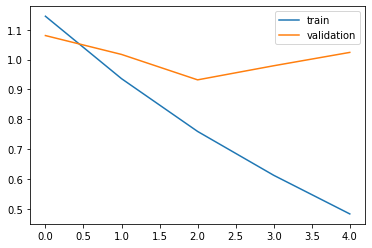

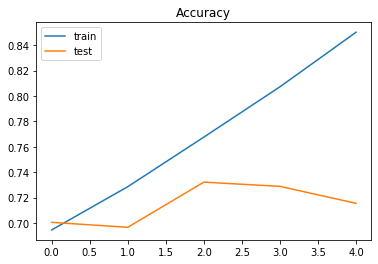

In [8]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show();

In [9]:
test_clean = []
for review in test.notes:
    test_clean.append(review)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(test_clean)
test_seq = tokenizer.texts_to_sequences(test_clean)
word_index = tokenizer.word_index
lengths = []
for review in test_seq:
    lengths.append(len(review))
lengths = pd.DataFrame(lengths, columns=['counts'])
lengths.counts.describe()
max_review_length = 202
test_pad = pad_sequences(train_seq, maxlen = max_review_length)
Y = pd.get_dummies(non_test['protesterdemand1']).values

scores = model.evaluate(test_pad, Y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

pred = model.predict(test_pad[0])
print(pred, np.argmax(pred))


Accuracy: 85.41%


ValueError: Error when checking input: expected embedding_2_input to have shape (202,) but got array with shape (1,)